<div style="text-align: center">
    <img src="../figures/JuliaEO2024_banner.png" alt="Descriptive Image Text" style="border:1px solid black"/>
</div>



The objectives of this workshop are the following:


- **Understand SAR Imagery**: Gain an understanding of SAR imagery, its properties, and why it's advantageous for maritime surveillance.
- **Data Handling**: Learn how to acquire and prepare SAR data from the Sentinel-1 satellite.
- **Apply Machine Learning**: Explore machine learning techniques, from basic classification to object detection models.
- **Real-World Application**: Gain practical skills in applying these models to real-world SAR data for effective maritime surveillance.



____________________



## Notebooks

- 1: [Sentinel-1 data acquisition](1_Data_acqusition.ipynb)
- 2: [Ship binary classification](2_Ship_binary_classification.ipynb)
- 3: [Two stage ship detection](3_two_stage_ship_detector.ipynb)
- 4: [One stage ship detection](4_One_stage_ship_detector.ipynb)

<div style="text-align: center">
    <img src="../figures/overview_notebooks.png" alt="Descriptive Image Text" width="800"/>
</div>



# Ship binary classification

 <a class="anchor" id="toc"></a>
-  [Objectives](#objectives)
-  [Binary Classification with CNNs](#binary_classification)
-  [Include modules](#init)
-  [Data](#data)
-  [Simple binary classifier](#classifier)
-  [Finding Thresholds](#threshold)
-  [Testing](#testing)




### Objectives
 <a class="anchor" id="objectives"></a>
Back to [Table of Content](#toc)

The objectives of this notebook are the following:
1. Implement a simple binary classifier for ship classification using Julia and Flux.
2. Train the classifier on a small ship/no-ship dataset.
3. Test the classifier.
4. Find the optimal threshold for the classifier.

### Binary Classification with CNNs

 <a class="anchor" id="binary_classification"></a>
Back to [Table of Content](#toc)


Convolutional Neural Networks (CNNs) have revolutionized the field of image processing and classification. A binary classification task involves distinguishing between two classes, such as identifying whether an image contains a specific object or not. CNNs are particularly well-suited for this task due to their ability to extract and learn spatial hierarchies of features from images.


- **Convolutional Layers**: These layers apply a number of filters to the input. Each filter detects specific features, such as edges, textures, or more complex patterns in deeper layers.
- **Pooling Layers**: Pooling (typically max pooling) reduces the spatial size of the representation, decreasing the number of parameters and computation in the network, thereby also controlling overfitting.
- **Fully Connected Layers**: Towards the end of the network, fully connected layers use the features extracted by convolutional and pooling layers to determine the class of the input image.
- **Dropout**: Dropout is a regularization technique used in neural networks to prevent overfitting. During training, dropout randomly 'drops' (sets to zero) a proportion of neurons in the layer to which it is applied. This forces the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.
- **ReLU**: ReLU is a type of activation function that is defined as `f(x) = max(0, x)`. It introduces non-linearity in the network, allowing it to learn complex patterns.
- **Flatten**: The Flatten layer is used to convert the multi-dimensional output of convolutional and pooling layers into a 1D feature vector. This flattening is necessary because fully connected layers expect 1D input.

##### Loss Function for Binary Classification


In binary classification tasks, such as ship/no-ship detection, a common loss function is the binary cross-entropy loss. It measures the performance of a classification model whose output is a probability value between 0 and 1. The loss function for a single example is:

`-mean(targets .* log.(predictions) + (1 .- targets) .* log.(1 .- predictions))`

- **Interpreting the Formula**: For each prediction and the actual target, it calculates two things:
    - The log-loss for the positive class (`targets .* log.(predictions)`)
    - The log-loss for the negative class (`(1 .- targets) .* log.(1 .- predictions)`)

this loss function is effective because it penalizes incorrect predictions far from the actual class more heavily. It is suitable for models that output a probability like sigmoid activation in the output layer.



____________________


In the context of maritime surveillance, a binary CNN can be trained to differentiate between two classes: images containing ships ('ship') and images containing other objects ('no ship'). 

**Training Process**

1. **Dataset Preparation**: Collect a labeled dataset consisting of SAR images, categorically marked as '1' (for ships) or '0' (for no ships).
2. **Feature Learning**: The CNN learns to identify features indicative of the presence or absence of ships, like specific shapes or textures, in the convolutional layers.
3. **Classification**: In the final layer, the network makes a prediction about the presence of a ship in the input image on a score from 0 to 1. A score closer to 1 indicates a higher probability of a ship being present, while a score closer to 0 indicates a higher probability of no ship being present.


**Advantages in Maritime Surveillance** 

- **Accuracy**: CNNs can achieve high accuracy in distinguishing ships from other objects or sea clutter, making them reliable for automated surveillance systems.
- **Efficiency**: Once trained, CNNs can process large volumes of imagery rapidly, aiding in real-time surveillance applications.
- **Adaptability**: CNNs can be fine-tuned to adapt to different types of ships, lighting conditions, and backgrounds found in maritime environments.

Through the use of binary CNNs, maritime surveillance systems can be significantly enhanced, offering a robust tool for monitoring and maintaining security in marine areas.



Below, we see an image of (right): a ship and (left): not a ship.

<div style="text-align: center">
    <img src="../figures/notebooks/no_ship.png" alt="Not a ship" style="width: 400px; border: 1px solid black; display: inline-block;"/>
    <img src="../figures/notebooks/ship.png" alt="Ship" style="width: 400px; border: 1px solid black; display: inline-block;"/>
</div>


## Init
 <a class="anchor" id="init"></a>
Back to [Table of Content](#toc)

In [1]:
using Pkg
include("../src/test_name.jl")
using .Test_name
using Plots
using Images

## Loading the dataset
 <a class="anchor" id="data"></a>
Back to [Table of Content](#toc)

The dataset conists of hand-labelled images of ships or icebergs (using AIS for assistance). The images are acquired from the Sentinel-1 satellite in arctic iceberg infested waters.

Details:
- Sentinel-1 IW GRDH HH/HV images
- Subsets of 75x75 pixels
- Sigma naught calibrated values in dB
- Nomalised 

For more details on the data, see https://www.kaggle.com/c/statoil-iceberg-classifier-challenge

In [2]:
json_file = "../data/train.json";
json_data = Test_name.Ship_detector.load_json_data(json_file);
images, labels= Test_name.Ship_detector.create_dataset(json_data);
train_X, train_Y, val_X, val_Y, test_X, test_Y = Test_name.Ship_detector.shuffle_and_split_data(images, labels, 0.7, 0.1);

println("Number of training examples: $(size(train_X)) \nNumber of validation examples: $(size(val_X)) \nNumber of testing examples: $(size(test_X))", );

Number of training examples: (1123,) 
Number of validation examples: (160,) 
Number of testing examples: (321,)


1


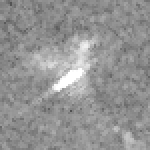

In [3]:
println(train_Y[2]);
Images.Gray.(train_X[2][:,:,1])

<div class="alert alert-block alert-info"> <b>Task: </b>
1. Display different images from the dataset to familiarize yourself with the data.

## Simple binary classifier:
 <a class="anchor" id="classifier"></a>
Back to [Table of Content](#toc)

We will start by making a simple binary classifier. 

In [4]:
println("Size of images: $(size(train_X[1]))")

Size of images: (75, 75, 2)


In [5]:
model  = Test_name.Ship_detector.Model.Binary_model.create_model(
                                                                input_channels =size(train_X[1])[3], 
                                                                img_size=size(train_X[1])[1:2], 
                                                                filter_sizes=[3, 3, 3], 
                                                                num_filters=[64, 64, 128], 
                                                                use_maxpool=[true, true, true], 
                                                                use_dropout=[0.3, 0.3, 0.3], 
                                                                dense_layers=[64], 
                                                                final_dense_units=1);
model

Chain(
  Conv((3, 3), 2 => 64, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Dropout(0.3),
  Conv((3, 3), 64 => 64, relu),         # 36_928 parameters
  MaxPool((2, 2)),
  Dropout(0.3),
  Conv((3, 3), 64 => 128, relu),        # 73_856 parameters
  MaxPool((2, 2)),
  Dropout(0.3),
  Flux.flatten,
  Dense(6272 => 64, relu),              # 401_472 parameters
  Dense(64 => 1),                       # 65 parameters
  NNlib.σ,
)                   # Total: 10 arrays, 513_537 parameters, 1.961 MiB.

<div class="alert alert-block alert-info"> <b>Task: </b>

1. Try to make a simple CNN binary classifier using Flux.

2. Change some of the parameters and see how it affects the arcitecture, e.g., the number of paramters. 

In [6]:
# Hyperparameters
epochs = 1500;
learning_rate = 0.001;
batch_size = 128;

In [7]:
loss_fn = Test_name.Ship_detector.Model.Binary_model.loss_fn;

In [8]:
train_X_prepared = cat(train_X..., dims=4);
val_X_prepared = cat(val_X..., dims=4);
train_Y_prepared = hcat(train_Y...);
val_Y_prepared = hcat(val_Y...);

In [9]:
train_losses, train_accuracies, val_losses, val_accuracies =  Test_name.Ship_detector.Model.Binary_model.train_model(model, train_X_prepared, train_Y_prepared, val_X_prepared, val_Y_prepared, epochs, learning_rate, batch_size, loss_fn);

┌ Info: Epoch 1
│   train_loss = 0.6928084842604599
│   val_loss = 0.6929763932810262
│   train_accuracy = 0.5136258417508418
│   val_accuracy = 0.5125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 1
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 2
│   train_loss = 0.6922278526237081
│   val_loss = 0.6918942841009139
│   train_accuracy = 0.5291017817059483
│   val_accuracy = 0.50625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 2
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 3
│   train_loss = 0.6902858242922592
│   val_loss = 0.6912124740397882
│   train_accuracy = 0.5291017817059483
│   val_accuracy = 0.50625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 3
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 4
│   train_loss = 0.6916551218967122
│   val_loss = 0.6918138625762807
│   train_accuracy = 0.5296103395061729
│   val_accuracy = 0.50625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 5
│   train_loss = 0.6906625868255307
│   val_loss = 0.6905434436039366
│   train_accuracy = 0.5280846661054994
│   val_accuracy = 0.50625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 5
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 6
│   train_loss = 0.6905781575213731
│   val_loss = 0.6893384681954964
│   train_accuracy = 0.5285932239057239
│   val_accuracy = 0.50625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 6
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 7
│   train_loss = 0.6885596946710515
│   val_loss = 0.6852007131629143
│   train_accuracy = 0.5278303872053871
│   val_accuracy = 0.50625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 7
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 8
│   train_loss = 0.6859090749664519
│   val_loss = 0.680773617725883
│   train_accuracy = 0.5296103395061729
│   val_accuracy = 0.5125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 8
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 9
│   train_loss = 0.6796457138833639
│   val_loss = 0.6741846801011542
│   train_accuracy = 0.5567743406285073
│   val_accuracy = 0.60625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 9
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 10
│   train_loss = 0.6728074966374638
│   val_loss = 0.6657386041133821
│   train_accuracy = 0.6306029040404041
│   val_accuracy = 0.6625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 10
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 11
│   train_loss = 0.6673725889449276
│   val_loss = 0.6843752048953274
│   train_accuracy = 0.619572460718294
│   val_accuracy = 0.63125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 12
│   train_loss = 0.6570454908747279
│   val_loss = 0.6608415406421955
│   train_accuracy = 0.6721643518518519
│   val_accuracy = 0.70625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 12
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 13
│   train_loss = 0.621086702098811
│   val_loss = 0.6253310375223113
│   train_accuracy = 0.7147867564534232
│   val_accuracy = 0.73125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 13
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 14
│   train_loss = 0.5782524656340022
│   val_loss = 0.5876853162183949
│   train_accuracy = 0.7324021464646465
│   val_accuracy = 0.66875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 14
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 15
│   train_loss = 0.5300800786018436
│   val_loss = 0.517642602148819
│   train_accuracy = 0.755331088664422
│   val_accuracy = 0.7625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 15
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 16
│   train_loss = 0.5018699134054443
│   val_loss = 0.5159427841454786
│   train_accuracy = 0.7797418630751963
│   val_accuracy = 0.74375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 16
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 17
│   train_loss = 0.48772777928773486
│   val_loss = 0.4899227565750728
│   train_accuracy = 0.7693251964085297
│   val_accuracy = 0.75625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 17
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 18
│   train_loss = 0.4743469414074004
│   val_loss = 0.48834869747635024
│   train_accuracy = 0.7889309764309764
│   val_accuracy = 0.7875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 18
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 19
│   train_loss = 0.43140405051808595
│   val_loss = 0.4672282903397195
│   train_accuracy = 0.8223204264870931
│   val_accuracy = 0.7625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 19
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 20
│   train_loss = 0.4153357775803068
│   val_loss = 0.45739606486264933
│   train_accuracy = 0.812771815375982
│   val_accuracy = 0.78125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 20
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 21
│   train_loss = 0.4081862888101716
│   val_loss = 0.46663424527352204
│   train_accuracy = 0.8096590909090909
│   val_accuracy = 0.775
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 22
│   train_loss = 0.39143221703441394
│   val_loss = 0.4218574584376329
│   train_accuracy = 0.820584315375982
│   val_accuracy = 0.8
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 22
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 23
│   train_loss = 0.3624721950128327
│   val_loss = 0.41627174451930243
│   train_accuracy = 0.8446355920314255
│   val_accuracy = 0.81875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 23
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 24
│   train_loss = 0.3615961666409767
│   val_loss = 0.39973653732675374
│   train_accuracy = 0.8362531565656566
│   val_accuracy = 0.79375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 24
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 25
│   train_loss = 0.34157574286738607
│   val_loss = 0.42263278385994657
│   train_accuracy = 0.8430485409652076
│   val_accuracy = 0.8125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 26
│   train_loss = 0.3300921556156202
│   val_loss = 0.3972727375546198
│   train_accuracy = 0.8569374298540965
│   val_accuracy = 0.8125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 26
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 27
│   train_loss = 0.3125226878424052
│   val_loss = 0.4040889015412015
│   train_accuracy = 0.8676083754208754
│   val_accuracy = 0.81875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 28
│   train_loss = 0.311287307587534
│   val_loss = 0.4032135810507424
│   train_accuracy = 0.8605148709315376
│   val_accuracy = 0.825
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 29
│   train_loss = 0.3036635943694622
│   val_loss = 0.3774347441066358
│   train_accuracy = 0.8651094276094277
│   val_accuracy = 0.83125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 29
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 30
│   train_loss = 0.3016507165906636
│   val_loss = 0.38491934895658875
│   train_accuracy = 0.8678626543209877
│   val_accuracy = 0.79375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 31
│   train_loss = 0.2977221181908192
│   val_loss = 0.4403129936398509
│   train_accuracy = 0.8711858164983165
│   val_accuracy = 0.79375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 32
│   train_loss = 0.2924994484520145
│   val_loss = 0.3787977589518978
│   train_accuracy = 0.8695987654320988
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 33
│   train_loss = 0.2883031156584946
│   val_loss = 0.3537041349310375
│   train_accuracy = 0.8806292087542088
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 33
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 34
│   train_loss = 0.2681779877315102
│   val_loss = 0.34288498780812643
│   train_accuracy = 0.8933957631874299
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 34
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 35
│   train_loss = 0.2736807014616297
│   val_loss = 0.36769663603112573
│   train_accuracy = 0.8796559343434344
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 36
│   train_loss = 0.26962598664973536
│   val_loss = 0.37117192261502463
│   train_accuracy = 0.880883487654321
│   val_accuracy = 0.83125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 37
│   train_loss = 0.2673162635295402
│   val_loss = 0.33497588243952936
│   train_accuracy = 0.8864513187429854
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 37
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 38
│   train_loss = 0.2656700356600635
│   val_loss = 0.3321909791613657
│   train_accuracy = 0.8895640432098766
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 38
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 39
│   train_loss = 0.2624676653551272
│   val_loss = 0.3402895779902436
│   train_accuracy = 0.8910458754208754
│   val_accuracy = 0.8125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 40
│   train_loss = 0.25307519218851104
│   val_loss = 0.35298892801323567
│   train_accuracy = 0.899726430976431
│   val_accuracy = 0.8375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 41
│   train_loss = 0.2603995323784221
│   val_loss = 0.3278326034217516
│   train_accuracy = 0.8970170454545454
│   val_accuracy = 0.83125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 41
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 42
│   train_loss = 0.26547037503360715
│   val_loss = 0.3872027991334041
│   train_accuracy = 0.8855832631874299
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 43
│   train_loss = 0.2598913751502842
│   val_loss = 0.3283555317191799
│   train_accuracy = 0.8967189253647587
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 44
│   train_loss = 0.2607601346722414
│   val_loss = 0.3606991051593621
│   train_accuracy = 0.8920191498316498
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 45
│   train_loss = 0.23065069118654233
│   val_loss = 0.3594318194766034
│   train_accuracy = 0.9018220398428731
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 46
│   train_loss = 0.24006178030836464
│   val_loss = 0.3560441143672298
│   train_accuracy = 0.8988583754208754
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 47
│   train_loss = 0.22814348854363273
│   val_loss = 0.29823924270171315
│   train_accuracy = 0.914886714365881
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 47
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 48
│   train_loss = 0.22382363220395707
│   val_loss = 0.3272604326447094
│   train_accuracy = 0.9096783810325477
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 49
│   train_loss = 0.2232337448184241
│   val_loss = 0.32285119997171874
│   train_accuracy = 0.9058466610549945
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 50
│   train_loss = 0.22470565576558915
│   val_loss = 0.35329742399872854
│   train_accuracy = 0.9097835998877666
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 51
│   train_loss = 0.2220891302297228
│   val_loss = 0.29905098049849677
│   train_accuracy = 0.910292157687991
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 52
│   train_loss = 0.2126348462413512
│   val_loss = 0.30685656352018204
│   train_accuracy = 0.9161581088664421
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 53
│   train_loss = 0.20735413136296615
│   val_loss = 0.31517019037447086
│   train_accuracy = 0.9158599887766555
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 54
│   train_loss = 0.2078901286948004
│   val_loss = 0.317326225766866
│   train_accuracy = 0.912028268799102
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 55
│   train_loss = 0.2043735299730084
│   val_loss = 0.32743464849520026
│   train_accuracy = 0.919840768799102
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 56
│   train_loss = 0.20000571682333662
│   val_loss = 0.3044178488983814
│   train_accuracy = 0.9204545454545454
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 57
│   train_loss = 0.1940512227794945
│   val_loss = 0.3026364305073117
│   train_accuracy = 0.9195864898989898
│   val_accuracy = 0.83125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 58
│   train_loss = 0.2169267991637218
│   val_loss = 0.32271948492074476
│   train_accuracy = 0.9207088243546576
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 59
│   train_loss = 0.20037406180072184
│   val_loss = 0.2768269151834045
│   train_accuracy = 0.9233129910213242
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 59
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 60
│   train_loss = 0.20659862533570064
│   val_loss = 0.3147495660806835
│   train_accuracy = 0.91039737654321
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 61
│   train_loss = 0.21445372080656194
│   val_loss = 0.3195767105849266
│   train_accuracy = 0.9086612654320988
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 62
│   train_loss = 0.20710222768491293
│   val_loss = 0.2906975693532331
│   train_accuracy = 0.9238215488215489
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 63
│   train_loss = 0.19188694546213028
│   val_loss = 0.3475034389842827
│   train_accuracy = 0.9246896043771043
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 64
│   train_loss = 0.2089864535239558
│   val_loss = 0.3653997176679614
│   train_accuracy = 0.9195864898989898
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 65
│   train_loss = 0.19641612484462778
│   val_loss = 0.297935714473072
│   train_accuracy = 0.9214716610549945
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 66
│   train_loss = 0.18400734314204115
│   val_loss = 0.29296409057142825
│   train_accuracy = 0.9271447109988777
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 67
│   train_loss = 0.18558755627457932
│   val_loss = 0.34391186716801636
│   train_accuracy = 0.9285213243546576
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 68
│   train_loss = 0.19394029311441832
│   val_loss = 0.2961691115170443
│   train_accuracy = 0.9221906565656565
│   val_accuracy = 0.90625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 69
│   train_loss = 0.17732252402229634
│   val_loss = 0.28896590897895724
│   train_accuracy = 0.9351062710437711
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 70
│   train_loss = 0.1948236028140502
│   val_loss = 0.2908106155767947
│   train_accuracy = 0.9143781565656565
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 71
│   train_loss = 0.1861608390106101
│   val_loss = 0.2998224693247344
│   train_accuracy = 0.9341329966329965
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 72
│   train_loss = 0.18127861497448197
│   val_loss = 0.2893314681597533
│   train_accuracy = 0.9215768799102132
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 73
│   train_loss = 0.21225927870380834
│   val_loss = 0.31358639996102305
│   train_accuracy = 0.9209631032547699
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 74
│   train_loss = 0.18881760154081967
│   val_loss = 0.26593470686110104
│   train_accuracy = 0.927653268799102
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 74
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 75
│   train_loss = 0.16977883869998878
│   val_loss = 0.2814111958936088
│   train_accuracy = 0.935465768799102
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 76
│   train_loss = 0.1895968337994039
│   val_loss = 0.32193379515629117
│   train_accuracy = 0.9220854377104377
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 77
│   train_loss = 0.18348465286178609
│   val_loss = 0.3119876955469466
│   train_accuracy = 0.9268904320987654
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 78
│   train_loss = 0.17176077791414956
│   val_loss = 0.3240852879950582
│   train_accuracy = 0.93474677328844
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 79
│   train_loss = 0.16468440159565156
│   val_loss = 0.2893970592207134
│   train_accuracy = 0.9351062710437711
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 80
│   train_loss = 0.15773229131719646
│   val_loss = 0.3344805578948275
│   train_accuracy = 0.9395517676767676
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 81
│   train_loss = 0.16384808127348116
│   val_loss = 0.2826642266092671
│   train_accuracy = 0.933729657687991
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 82
│   train_loss = 0.1538481923213954
│   val_loss = 0.28194429689717865
│   train_accuracy = 0.9428135521885521
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 83
│   train_loss = 0.14760824150208907
│   val_loss = 0.30043210498055484
│   train_accuracy = 0.9395956088664421
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 84
│   train_loss = 0.1457015353099664
│   val_loss = 0.30472571189549313
│   train_accuracy = 0.9442953843995512
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 85
│   train_loss = 0.14824239121092628
│   val_loss = 0.2972109410739364
│   train_accuracy = 0.9411826599326599
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 86
│   train_loss = 0.1689293504015634
│   val_loss = 0.3470757138777336
│   train_accuracy = 0.9273989898989898
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 87
│   train_loss = 0.15393233347989507
│   val_loss = 0.32328814374337467
│   train_accuracy = 0.9484866021324354
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 88
│   train_loss = 0.15525777776767521
│   val_loss = 0.27010683524113627
│   train_accuracy = 0.9374561588103254
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 89
│   train_loss = 0.14607359750350754
│   val_loss = 0.31157386510219187
│   train_accuracy = 0.9385346520763187
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 90
│   train_loss = 0.13723693166988873
│   val_loss = 0.30632120353173004
│   train_accuracy = 0.9476623877665544
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 91
│   train_loss = 0.15213197517674792
│   val_loss = 0.3331564549828348
│   train_accuracy = 0.9455229377104377
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 92
│   train_loss = 0.1340931056811782
│   val_loss = 0.2953776622008687
│   train_accuracy = 0.9476185465768798
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 93
│   train_loss = 0.14968969792354636
│   val_loss = 0.295343682098088
│   train_accuracy = 0.9404198232323231
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 94
│   train_loss = 0.14107240157785655
│   val_loss = 0.293189028344816
│   train_accuracy = 0.9495037177328844
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 95
│   train_loss = 0.1407215373689314
│   val_loss = 0.4562732673907111
│   train_accuracy = 0.9476185465768798
│   val_accuracy = 0.8
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 96
│   train_loss = 0.14053479964811522
│   val_loss = 0.28504599186913887
│   train_accuracy = 0.9497579966329965
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 97
│   train_loss = 0.15255926119518828
│   val_loss = 0.26591542457680184
│   train_accuracy = 0.935465768799102
│   val_accuracy = 0.9
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81
┌ Info: New best model saved at epoch 97
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:107


┌ Info: Epoch 98
│   train_loss = 0.12943387977730147
│   val_loss = 0.2949184708552733
│   train_accuracy = 0.9540982744107743
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 99
│   train_loss = 0.12148068498776936
│   val_loss = 0.3232780964851366
│   train_accuracy = 0.9548172699214366
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 100
│   train_loss = 0.1287470338692631
│   val_loss = 0.34553190868269706
│   train_accuracy = 0.9544577721661055
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 101
│   train_loss = 0.13485019280205843
│   val_loss = 0.3378337955045492
│   train_accuracy = 0.9468995510662178
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 102
│   train_loss = 0.14681604618034505
│   val_loss = 0.4020114147708241
│   train_accuracy = 0.9445496632996632
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 103
│   train_loss = 0.16704054669327484
│   val_loss = 0.42257972571568414
│   train_accuracy = 0.9328616021324354
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 104
│   train_loss = 0.15849918091272264
│   val_loss = 0.4308642939029916
│   train_accuracy = 0.9325021043771043
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 105
│   train_loss = 0.15281241442752322
│   val_loss = 0.2898429251903504
│   train_accuracy = 0.9475133277216611
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 106
│   train_loss = 0.13420456155544097
│   val_loss = 0.33704126828030223
│   train_accuracy = 0.9498632154882155
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 107
│   train_loss = 0.12880828255460394
│   val_loss = 0.30223215442886087
│   train_accuracy = 0.9586928310886643
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 108
│   train_loss = 0.11967239827055098
│   val_loss = 0.29900862633715575
│   train_accuracy = 0.9504769921436588
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 109
│   train_loss = 0.12458873308288683
│   val_loss = 0.3664795216086362
│   train_accuracy = 0.9491003787878787
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 110
│   train_loss = 0.11994802324547993
│   val_loss = 0.2925671684021337
│   train_accuracy = 0.9627788299663299
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 111
│   train_loss = 0.11732764856286461
│   val_loss = 0.3527738548788085
│   train_accuracy = 0.9533354377104377
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 112
│   train_loss = 0.11473258842704458
│   val_loss = 0.3019586127201585
│   train_accuracy = 0.9530811588103254
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 113
│   train_loss = 0.11216360014978528
│   val_loss = 0.31911624553913315
│   train_accuracy = 0.9599203843995512
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 114
│   train_loss = 0.10416463744102734
│   val_loss = 0.3320443311626348
│   train_accuracy = 0.9636468855218854
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 115
│   train_loss = 0.10774663709792444
│   val_loss = 0.30148115879629667
│   train_accuracy = 0.9657424943883277
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 116
│   train_loss = 0.09930882079871348
│   val_loss = 0.3328776626783997
│   train_accuracy = 0.9676276655443322
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 117
│   train_loss = 0.09966989023110745
│   val_loss = 0.30645408260155405
│   train_accuracy = 0.9703370510662178
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 118
│   train_loss = 0.09388542843159103
│   val_loss = 0.3391058121404295
│   train_accuracy = 0.9751858866442199
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 119
│   train_loss = 0.0964285073987705
│   val_loss = 0.3393617249046113
│   train_accuracy = 0.9700827721661055
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 120
│   train_loss = 0.09375941505927775
│   val_loss = 0.30401729009439543
│   train_accuracy = 0.9717136644219977
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 121
│   train_loss = 0.0872915094726931
│   val_loss = 0.3198989502467718
│   train_accuracy = 0.9688552188552187
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 122
│   train_loss = 0.08921294397426753
│   val_loss = 0.3262582057013561
│   train_accuracy = 0.9731954966329965
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 123
│   train_loss = 0.08976601098401255
│   val_loss = 0.3419417293610955
│   train_accuracy = 0.9709508277216611
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 124
│   train_loss = 0.09992215502736276
│   val_loss = 0.3900357342369528
│   train_accuracy = 0.9697232744107743
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 125
│   train_loss = 0.0907322597886622
│   val_loss = 0.31771418493885917
│   train_accuracy = 0.9777900533108865
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 126
│   train_loss = 0.08926441638577234
│   val_loss = 0.3377271576256047
│   train_accuracy = 0.9697232744107743
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 127
│   train_loss = 0.08069974597211464
│   val_loss = 0.3188828985739156
│   train_accuracy = 0.9743178310886643
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 128
│   train_loss = 0.09011129971918984
│   val_loss = 0.323497283810847
│   train_accuracy = 0.9671191077441077
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 129
│   train_loss = 0.09974489691056648
│   val_loss = 0.42902648720078806
│   train_accuracy = 0.9686009399551067
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 130
│   train_loss = 0.08632046424281202
│   val_loss = 0.3090331742164754
│   train_accuracy = 0.9737040544332211
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 131
│   train_loss = 0.07508998995171863
│   val_loss = 0.3931238822962151
│   train_accuracy = 0.9772814955106622
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 132
│   train_loss = 0.0725272656315072
│   val_loss = 0.33351690275338364
│   train_accuracy = 0.9803942199775533
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 133
│   train_loss = 0.07080888011672536
│   val_loss = 0.36381658395238653
│   train_accuracy = 0.9817708333333334
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 134
│   train_loss = 0.06463030108814266
│   val_loss = 0.3660856256385533
│   train_accuracy = 0.9862163299663299
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 135
│   train_loss = 0.07013449143744407
│   val_loss = 0.379951592810115
│   train_accuracy = 0.97978044332211
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 136
│   train_loss = 0.07514801532457431
│   val_loss = 0.37287606113342203
│   train_accuracy = 0.9775357744107743
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 137
│   train_loss = 0.07695661370122699
│   val_loss = 0.3706360826878426
│   train_accuracy = 0.9806484988776655
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 138
│   train_loss = 0.06262121483390784
│   val_loss = 0.3252683553363411
│   train_accuracy = 0.9867248877665544
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 139
│   train_loss = 0.06329005830065676
│   val_loss = 0.3813317415333314
│   train_accuracy = 0.9836121632996632
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 140
│   train_loss = 0.06427855622686736
│   val_loss = 0.401562034070024
│   train_accuracy = 0.9835069444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 141
│   train_loss = 0.0601114037059361
│   val_loss = 0.37814494064946536
│   train_accuracy = 0.9867248877665544
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 142
│   train_loss = 0.06782749900390156
│   val_loss = 0.37674612158804527
│   train_accuracy = 0.9838664421997755
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 143
│   train_loss = 0.06288404749563367
│   val_loss = 0.38381917312213265
│   train_accuracy = 0.9832526655443322
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 144
│   train_loss = 0.06385861821273102
│   val_loss = 0.3646458474660085
│   train_accuracy = 0.9809027777777778
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 145
│   train_loss = 0.06323509009005046
│   val_loss = 0.3812809205643304
│   train_accuracy = 0.9853482744107743
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 146
│   train_loss = 0.06072007653849059
│   val_loss = 0.3601246950784299
│   train_accuracy = 0.9832526655443322
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 147
│   train_loss = 0.04825220033812141
│   val_loss = 0.35475753497024715
│   train_accuracy = 0.9910651655443322
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 148
│   train_loss = 0.056239988326585326
│   val_loss = 0.35010205485275775
│   train_accuracy = 0.9847344977553311
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 149
│   train_loss = 0.06159046649800751
│   val_loss = 0.41509787621267524
│   train_accuracy = 0.9841207210998877
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 150
│   train_loss = 0.05881516181702758
│   val_loss = 0.32805094942611346
│   train_accuracy = 0.9829983866442199
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 151
│   train_loss = 0.04645332202021295
│   val_loss = 0.3517258507404549
│   train_accuracy = 0.9893290544332211
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 152
│   train_loss = 0.049058497012946095
│   val_loss = 0.41456940723862334
│   train_accuracy = 0.9895833333333334
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 153
│   train_loss = 0.06384899282140169
│   val_loss = 0.36424730614906653
│   train_accuracy = 0.9835069444444444
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 154
│   train_loss = 0.056247810845979185
│   val_loss = 0.30176934913218384
│   train_accuracy = 0.9869791666666666
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 155
│   train_loss = 0.0424251799377055
│   val_loss = 0.3791778796981604
│   train_accuracy = 0.9947916666666666
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 156
│   train_loss = 0.049778168894082105
│   val_loss = 0.3795559665759377
│   train_accuracy = 0.9847344977553311
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 157
│   train_loss = 0.053042794353557396
│   val_loss = 0.3537325513033812
│   train_accuracy = 0.9867248877665544
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 158
│   train_loss = 0.043451193425253755
│   val_loss = 0.37172406374159855
│   train_accuracy = 0.9930555555555556
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 159
│   train_loss = 0.0460570185044398
│   val_loss = 0.3938017477787052
│   train_accuracy = 0.9908108866442199
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 160
│   train_loss = 0.04772149847652712
│   val_loss = 0.36393932544198704
│   train_accuracy = 0.9913194444444444
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 161
│   train_loss = 0.03727781258352201
│   val_loss = 0.38217929438610626
│   train_accuracy = 0.9962734988776655
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 162
│   train_loss = 0.03788074691250451
│   val_loss = 0.39450742427230134
│   train_accuracy = 0.9947916666666666
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 163
│   train_loss = 0.03558939678967424
│   val_loss = 0.3690534543278515
│   train_accuracy = 0.9956597222222222
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 164
│   train_loss = 0.03334374657268327
│   val_loss = 0.42398940561749665
│   train_accuracy = 0.99540544332211
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 165
│   train_loss = 0.03657997642145196
│   val_loss = 0.3912545992583539
│   train_accuracy = 0.9936693322109988
│   val_accuracy = 0.8375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 166
│   train_loss = 0.03519141059031081
│   val_loss = 0.386810688115954
│   train_accuracy = 0.9939236111111112
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 167
│   train_loss = 0.040273910554483906
│   val_loss = 0.40778542645725696
│   train_accuracy = 0.9916789421997755
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 168
│   train_loss = 0.05129782017217045
│   val_loss = 0.5019614600129516
│   train_accuracy = 0.9838664421997755
│   val_accuracy = 0.83125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 169
│   train_loss = 0.07761412409250049
│   val_loss = 0.3746241122490341
│   train_accuracy = 0.9700827721661055
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 170
│   train_loss = 0.06662540690716444
│   val_loss = 0.3518666341356773
│   train_accuracy = 0.9789123877665544
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 171
│   train_loss = 0.05503658302570947
│   val_loss = 0.3479547855859994
│   train_accuracy = 0.9899428310886643
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 172
│   train_loss = 0.053840873420895025
│   val_loss = 0.4035266740414537
│   train_accuracy = 0.9862163299663299
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 173
│   train_loss = 0.05246185512369378
│   val_loss = 0.37840145687274773
│   train_accuracy = 0.9873386644219977
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 174
│   train_loss = 0.040662820619987945
│   val_loss = 0.32552203593998597
│   train_accuracy = 0.9947916666666666
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 175
│   train_loss = 0.032987333892727844
│   val_loss = 0.38494445710717395
│   train_accuracy = 0.9956597222222222
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 176
│   train_loss = 0.02740801049099273
│   val_loss = 0.3624710352437458
│   train_accuracy = 0.9965277777777778
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 177
│   train_loss = 0.025303849768729916
│   val_loss = 0.3893448773165696
│   train_accuracy = 0.9973958333333334
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 178
│   train_loss = 0.026725156410657005
│   val_loss = 0.40736536481747876
│   train_accuracy = 0.9973958333333334
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 179
│   train_loss = 0.028659692829422448
│   val_loss = 0.410223223812041
│   train_accuracy = 0.9947916666666666
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 180
│   train_loss = 0.025647266785270417
│   val_loss = 0.3835476793406052
│   train_accuracy = 0.9973958333333334
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 181
│   train_loss = 0.029451247239379173
│   val_loss = 0.43474807175090485
│   train_accuracy = 0.9939236111111112
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 182
│   train_loss = 0.02890831527626432
│   val_loss = 0.4194603757205293
│   train_accuracy = 0.9956597222222222
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 183
│   train_loss = 0.024249348031039373
│   val_loss = 0.3792532755484509
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 184
│   train_loss = 0.028442064802019256
│   val_loss = 0.3592042725189504
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 185
│   train_loss = 0.02471047952252489
│   val_loss = 0.33800247621953244
│   train_accuracy = 0.9980096099887766
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 186
│   train_loss = 0.022171113539608465
│   val_loss = 0.37718971092321785
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 187
│   train_loss = 0.01923845336694304
│   val_loss = 0.39717057673376355
│   train_accuracy = 0.9980096099887766
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 188
│   train_loss = 0.020067570939460752
│   val_loss = 0.3717865960938136
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 189
│   train_loss = 0.019134303152849225
│   val_loss = 0.38958260441699943
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 190
│   train_loss = 0.01643045561527734
│   val_loss = 0.41559228980830937
│   train_accuracy = 0.9973958333333334
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 191
│   train_loss = 0.019777503080536996
│   val_loss = 0.4060082340652319
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 192
│   train_loss = 0.017408896632685435
│   val_loss = 0.39028987482033367
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 193
│   train_loss = 0.016705461826652862
│   val_loss = 0.3776404529221549
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 194
│   train_loss = 0.01730270570108967
│   val_loss = 0.38461176846697653
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 195
│   train_loss = 0.020426700024160385
│   val_loss = 0.38616822912240756
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 196
│   train_loss = 0.022010520958538907
│   val_loss = 0.3867149710252117
│   train_accuracy = 0.9973958333333334
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 197
│   train_loss = 0.019065858781685027
│   val_loss = 0.4157131470167233
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 198
│   train_loss = 0.0163882027026286
│   val_loss = 0.4026923808441728
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 199
│   train_loss = 0.0164835232653414
│   val_loss = 0.4832624815190723
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.83125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 200
│   train_loss = 0.015572941055376096
│   val_loss = 0.4392737562989443
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 201
│   train_loss = 0.013486784635156797
│   val_loss = 0.4432399864507917
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 202
│   train_loss = 0.014032616518501977
│   val_loss = 0.4528504288030918
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 203
│   train_loss = 0.01508753588245889
│   val_loss = 0.4763860092541451
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 204
│   train_loss = 0.01258800203504146
│   val_loss = 0.41972108633384736
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 205
│   train_loss = 0.014872061193849833
│   val_loss = 0.4115506093973821
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 206
│   train_loss = 0.014878620023320013
│   val_loss = 0.4452460383518108
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 207
│   train_loss = 0.013386669069249273
│   val_loss = 0.4454023054654539
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 208
│   train_loss = 0.015116609528008008
│   val_loss = 0.5051275716147379
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 209
│   train_loss = 0.020474619773679103
│   val_loss = 0.43790084969200016
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 210
│   train_loss = 0.021523174964734788
│   val_loss = 0.39251949853593804
│   train_accuracy = 0.9962734988776655
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 211
│   train_loss = 0.01651014655959285
│   val_loss = 0.41986104478612807
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 212
│   train_loss = 0.02184786701138129
│   val_loss = 0.4363980675011304
│   train_accuracy = 0.9973958333333334
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 213
│   train_loss = 0.01825684122430713
│   val_loss = 0.3942551394612248
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 214
│   train_loss = 0.015471079541691024
│   val_loss = 0.4367582996005849
│   train_accuracy = 0.9973958333333334
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 215
│   train_loss = 0.01779002449409245
│   val_loss = 0.46377001435108844
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 216
│   train_loss = 0.016696403226751096
│   val_loss = 0.4144472300887336
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 217
│   train_loss = 0.015102601821685185
│   val_loss = 0.4053567062318038
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 218
│   train_loss = 0.01781141199563084
│   val_loss = 0.44299181358181217
│   train_accuracy = 0.9973958333333334
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 219
│   train_loss = 0.017404096930312602
│   val_loss = 0.48230155375205835
│   train_accuracy = 0.9988776655443322
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 220
│   train_loss = 0.021029206349292586
│   val_loss = 0.40544936108488133
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 221
│   train_loss = 0.012012328628456498
│   val_loss = 0.45491862500447644
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 222
│   train_loss = 0.01119937163335781
│   val_loss = 0.47382655448388
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 223
│   train_loss = 0.009924122329499945
│   val_loss = 0.4616308976828457
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 224
│   train_loss = 0.009972658410007416
│   val_loss = 0.43029821068381624
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 225
│   train_loss = 0.009080181892804615
│   val_loss = 0.46432719477329754
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 226
│   train_loss = 0.009007512822022506
│   val_loss = 0.430810086002454
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 227
│   train_loss = 0.011004989293303681
│   val_loss = 0.43428666877786853
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 228
│   train_loss = 0.010017539655926708
│   val_loss = 0.48828784491116545
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 229
│   train_loss = 0.009409076295339358
│   val_loss = 0.44750162215058653
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 230
│   train_loss = 0.01148246053739601
│   val_loss = 0.4785595096913979
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 231
│   train_loss = 0.01599612241915737
│   val_loss = 0.476202111299011
│   train_accuracy = 0.9956597222222222
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 232
│   train_loss = 0.009857671874807888
│   val_loss = 0.40635771954636646
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 233
│   train_loss = 0.010752286970299594
│   val_loss = 0.4516719070745097
│   train_accuracy = 1.0
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 234
│   train_loss = 0.010645710798179858
│   val_loss = 0.4850676375661913
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 235
│   train_loss = 0.011935815506782358
│   val_loss = 0.4256617764447362
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 236
│   train_loss = 0.008322546758849046
│   val_loss = 0.5431971699676181
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 237
│   train_loss = 0.0064263127320792444
│   val_loss = 0.4623389303974791
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 238
│   train_loss = 0.005809855557761766
│   val_loss = 0.46022044522764516
│   train_accuracy = 1.0
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 239
│   train_loss = 0.005325651912527121
│   val_loss = 0.49963312982015645
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 240
│   train_loss = 0.009201563147458245
│   val_loss = 0.46543069795935094
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 241
│   train_loss = 0.00788561944818302
│   val_loss = 0.45822143582008434
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 242
│   train_loss = 0.005383846093569202
│   val_loss = 0.48070607576835045
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 243
│   train_loss = 0.004887459208059635
│   val_loss = 0.5048544059646132
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 244
│   train_loss = 0.005955173876036248
│   val_loss = 0.4861417081499904
│   train_accuracy = 1.0
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 245
│   train_loss = 0.007407905210410108
│   val_loss = 0.4358108324522062
│   train_accuracy = 1.0
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 246
│   train_loss = 0.005824790348087598
│   val_loss = 0.48169490688443917
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 247
│   train_loss = 0.004535644611272226
│   val_loss = 0.4974238990745068
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 248
│   train_loss = 0.005105805498399816
│   val_loss = 0.4819164673866192
│   train_accuracy = 1.0
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 249
│   train_loss = 0.006611929192497013
│   val_loss = 0.4426835335315003
│   train_accuracy = 1.0
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 250
│   train_loss = 0.008040613122063533
│   val_loss = 0.4568502070170323
│   train_accuracy = 1.0
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 251
│   train_loss = 0.006928100785109147
│   val_loss = 0.5107334388712101
│   train_accuracy = 1.0
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 252
│   train_loss = 0.006669152697649269
│   val_loss = 0.47029671501885606
│   train_accuracy = 1.0
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 253
│   train_loss = 0.005442170065921842
│   val_loss = 0.49944853522386545
│   train_accuracy = 1.0
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 254
│   train_loss = 0.005132282151847411
│   val_loss = 0.4637699778081215
│   train_accuracy = 1.0
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 255
│   train_loss = 0.0038898958320249723
│   val_loss = 0.48298425880159696
│   train_accuracy = 1.0
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 256
│   train_loss = 0.012995317180534625
│   val_loss = 0.5334962164182434
│   train_accuracy = 0.9971415544332211
│   val_accuracy = 0.8375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 257
│   train_loss = 0.015919531923111362
│   val_loss = 0.6116283566408455
│   train_accuracy = 0.9966329966329965
│   val_accuracy = 0.8375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 258
│   train_loss = 0.2601515169160472
│   val_loss = 0.35912673998002903
│   train_accuracy = 0.9259609988776655
│   val_accuracy = 0.825
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 259
│   train_loss = 0.1492904459629196
│   val_loss = 0.4229839168534081
│   train_accuracy = 0.9514941077441077
│   val_accuracy = 0.8375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 260
│   train_loss = 0.12245793207281147
│   val_loss = 0.3876799656204966
│   train_accuracy = 0.9606832210998877
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 261
│   train_loss = 0.07230846010466746
│   val_loss = 0.35645801311795816
│   train_accuracy = 0.9734497755331089
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 262
│   train_loss = 0.04423444095251941
│   val_loss = 0.39241512895466757
│   train_accuracy = 0.9960192199775533
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 263
│   train_loss = 0.03268484725329247
│   val_loss = 0.39379088771392623
│   train_accuracy = 0.9965277777777778
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 264
│   train_loss = 0.02890676302247669
│   val_loss = 0.3805599755322312
│   train_accuracy = 0.99540544332211
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 265
│   train_loss = 0.02150425745261665
│   val_loss = 0.39510411896449293
│   train_accuracy = 0.9973958333333334
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 266
│   train_loss = 0.016612021663580716
│   val_loss = 0.40592697767507085
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 267
│   train_loss = 0.01542683926298462
│   val_loss = 0.4223285293307207
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 268
│   train_loss = 0.01547852736107794
│   val_loss = 0.43298270274150746
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 269
│   train_loss = 0.014705769522353057
│   val_loss = 0.4107813994695578
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 270
│   train_loss = 0.0172266624380888
│   val_loss = 0.4218837158350798
│   train_accuracy = 0.9988776655443322
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 271
│   train_loss = 0.014143524624539876
│   val_loss = 0.445993793438315
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 272
│   train_loss = 0.01274935090541281
│   val_loss = 0.48444840315019155
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 273
│   train_loss = 0.012232410307057235
│   val_loss = 0.4262814467943638
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 274
│   train_loss = 0.011980188975785216
│   val_loss = 0.47022686424661747
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.84375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 275
│   train_loss = 0.01046287997212842
│   val_loss = 0.47215108514606563
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 276
│   train_loss = 0.008771432462684935
│   val_loss = 0.42146185494476407
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 277
│   train_loss = 0.012336603570757361
│   val_loss = 0.4462706639580551
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 278
│   train_loss = 0.011931074006581686
│   val_loss = 0.4952007150536935
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 279
│   train_loss = 0.0092941377589957
│   val_loss = 0.42497367896386573
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 280
│   train_loss = 0.018872245412839394
│   val_loss = 0.4622647293478169
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.85
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 281
│   train_loss = 0.017461706317487544
│   val_loss = 0.43483699586868607
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 282
│   train_loss = 0.019436697856202365
│   val_loss = 0.3997719521639798
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 283
│   train_loss = 0.015057581702481409
│   val_loss = 0.43076932763152964
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 284
│   train_loss = 0.009492455035113168
│   val_loss = 0.4071932412758309
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 285
│   train_loss = 0.008375144826691617
│   val_loss = 0.4081914300311234
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 286
│   train_loss = 0.007958960890138513
│   val_loss = 0.4122338550604927
│   train_accuracy = 1.0
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 287
│   train_loss = 0.007449328286318428
│   val_loss = 0.43989620289006803
│   train_accuracy = 1.0
│   val_accuracy = 0.9
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 288
│   train_loss = 0.008312935724379737
│   val_loss = 0.47539817447833255
│   train_accuracy = 1.0
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 289
│   train_loss = 0.005271753785763375
│   val_loss = 0.49523396813685505
│   train_accuracy = 1.0
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 290
│   train_loss = 0.00531718674349259
│   val_loss = 0.496107515930756
│   train_accuracy = 1.0
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 291
│   train_loss = 0.004702016276458277
│   val_loss = 0.4460705963988022
│   train_accuracy = 1.0
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 292
│   train_loss = 0.007461070103108722
│   val_loss = 0.46514290364762545
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 293
│   train_loss = 0.006403836857039274
│   val_loss = 0.48198995773082515
│   train_accuracy = 1.0
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 294
│   train_loss = 0.00842617139717621
│   val_loss = 0.5439007804849554
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 295
│   train_loss = 0.006145571370401344
│   val_loss = 0.4314546703171609
│   train_accuracy = 1.0
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 296
│   train_loss = 0.009973783154299979
│   val_loss = 0.4719693038001254
│   train_accuracy = 1.0
│   val_accuracy = 0.85625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 297
│   train_loss = 0.009073525483824776
│   val_loss = 0.4822270921253156
│   train_accuracy = 0.9982638888888888
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 298
│   train_loss = 0.005465597344887773
│   val_loss = 0.4500450858921477
│   train_accuracy = 0.9991319444444444
│   val_accuracy = 0.8625
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 299
│   train_loss = 0.005537404136962056
│   val_loss = 0.4606129293261959
│   train_accuracy = 1.0
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 300
│   train_loss = 0.004387154670094379
│   val_loss = 0.4516339131930539
│   train_accuracy = 1.0
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 301
│   train_loss = 0.004077207474103598
│   val_loss = 0.45100869105957014
│   train_accuracy = 1.0
│   val_accuracy = 0.89375
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 302
│   train_loss = 0.0035041633412177878
│   val_loss = 0.45998002644407593
│   train_accuracy = 1.0
│   val_accuracy = 0.8875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 303
│   train_loss = 0.0037131059025732344
│   val_loss = 0.49143025183610395
│   train_accuracy = 1.0
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 304
│   train_loss = 0.0034983667606395164
│   val_loss = 0.5596070146862693
│   train_accuracy = 1.0
│   val_accuracy = 0.88125
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 305
│   train_loss = 0.0040294394869416945
│   val_loss = 0.5081320653116125
│   train_accuracy = 1.0
│   val_accuracy = 0.86875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


┌ Info: Epoch 306
│   train_loss = 0.0040390711556709405
│   val_loss = 0.5364498866503328
│   train_accuracy = 1.0
│   val_accuracy = 0.875
└ @ Main.Test_name.Ship_detector.Model.Binary_model /Users/kaaso/Documents/coding/JuliaEO2024/src/ship_detector/model/classifyer/train_util.jl:81


<div class="alert alert-block alert-info"> <b>Task: </b>

1. Define some hyperparameters, e.g., learning rate and batch size.

2. Train the model for a few epochs and see how the loss changes.

3. Play around with the hyperparameters and model arcitecture to improve the model performance. 

4. Illustrate the loss of the model as a function of the number of epochs.

### plots

In [23]:

p1 = plot(1:length(train_losses), train_losses, label="Train Loss", color=:blue, linewidth=2, linestyle=:solid)
plot!(p1, 1:length(val_losses), val_losses, label="Validation Loss", color=:red, linewidth=2, linestyle=:dash)
title!(p1, "Training and Validation Loss")
xlabel!(p1, "Epoch")
ylabel!(p1, "Loss")

plot(p1,  layout=(1,1), size=(600, 400))



UndefVarError: UndefVarError: `train_losses` not defined

In [24]:


p2 = plot(1:length(train_accuracies), train_accuracies, label="Train Accuracy", color=:green, linewidth=2, linestyle=:solid)
plot!(p2, 1:length(val_accuracies), val_accuracies, label="Validation Accuracy", color=:purple, linewidth=2, linestyle=:dash)
title!(p2, "Training and Validation Accuracy")
xlabel!(p2, "Epoch")
ylabel!(p2, "Accuracy")

plot(p2,  layout=(1,1), size=(600, 400))


UndefVarError: UndefVarError: `train_accuracies` not defined

## Finding Thresholds
 <a class="anchor" id="threshold"></a>
Back to [Table of Content](#toc)

The output of the model is a probability between 0 and 1. We can use this to make a prediction, e.g., if the probability is above a certain threshold, we can say that the model predicts that the image contains a ship.
Often, a threshold of 0.5 is used, but this is not always optimal.





In [36]:
# preparing the images for the model
val_X_prepared =  Test_name.Ship_detector.Model.prepare_images(val_X)
val_labels = reshape(Float32.(val_Y), 1, :)
val_predictions = model(val_X_prepared);

<div class="alert alert-block alert-info"> <b>Task: </b>

1. Find a threshold for the model.

2. Illustrate the precision of the model as a function of the threshold.

3. Illustrate the recall of the model as a function of the threshold.

In [37]:
thresholds = 0:0.05:1
metrics_vector = Test_name.Ship_detector.Model.compute_metrics_vector(val_predictions, val_labels, thresholds);

### Plots

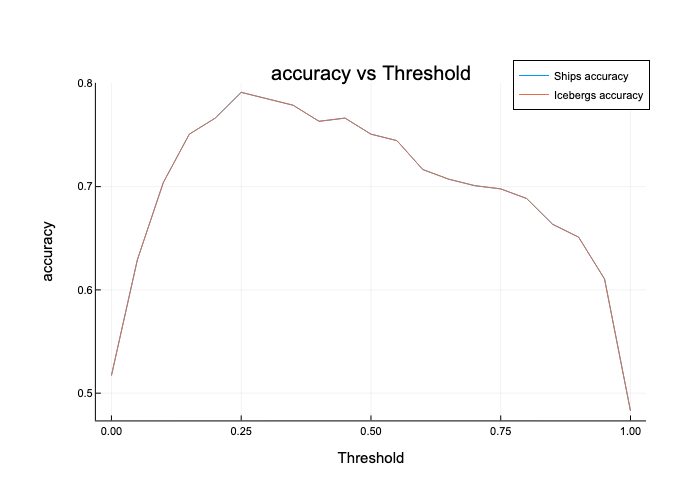

In [38]:
# Assuming metrics_vector contains your metrics data as previously computed
Test_name.Visualize.plot_combined_metrics(metrics_vector, :accuracy)

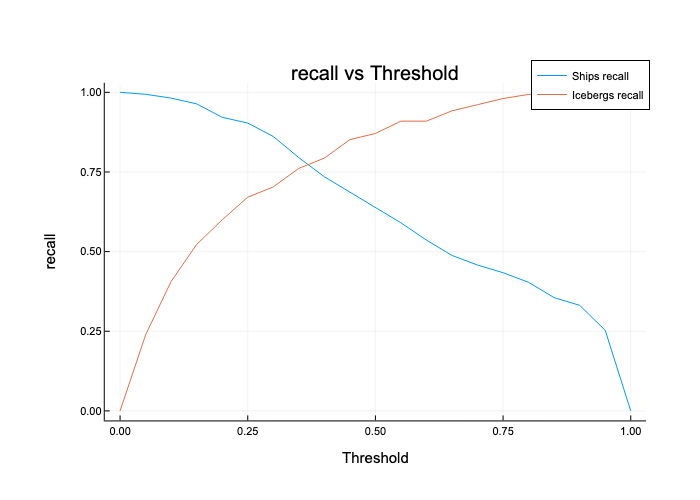

In [39]:
Test_name.Visualize.plot_combined_metrics(metrics_vector, :recall)

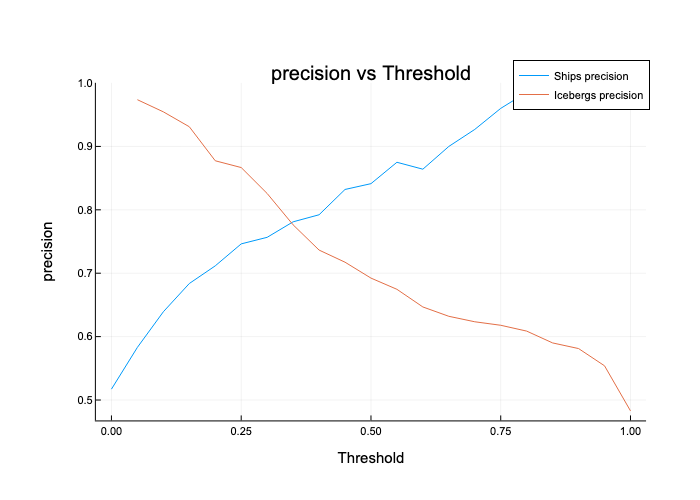

In [40]:
Test_name.Visualize.plot_combined_metrics(metrics_vector, :precision)

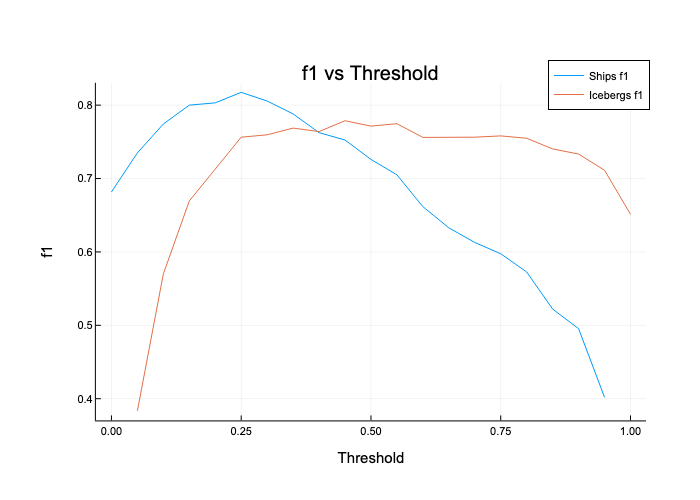

In [41]:
Test_name.Visualize.plot_combined_metrics(metrics_vector, :f1)


## Testing
 <a class="anchor" id="testing"></a>
Back to [Table of Content](#toc)

Using the threshold found above, we can now test the model on a test dataset. 



<div class="alert alert-block alert-info"> <b>Task: </b>

1. Test the model on the test dataset.


In [42]:
test_X_prepared =  Test_name.Ship_detector.Model.prepare_images(test_X);
test_labels = reshape(Float32.(test_Y), 1, :);
test_predictions = model(test_X_prepared);

In [43]:
specific_threshold = 0.25
test_metrics = Test_name.Ship_detector.Model.evaluate_test_set_at_threshold(test_predictions, test_labels, specific_threshold);

println("Test Metrics at threshold $specific_threshold:")
println("Ships - Precision: $(test_metrics.ships.precision), Recall: $(test_metrics.ships.recall), F1 Score: $(test_metrics.ships.f1), Accuracy: $(test_metrics.ships.accuracy)")
println("Icebergs - Precision: $(test_metrics.icebergs.precision), Recall: $(test_metrics.icebergs.recall), F1 Score: $(test_metrics.icebergs.f1), Accuracy: $(test_metrics.icebergs.accuracy)")


Test Metrics at threshold 0.25:
Ships - Precision: 0.7526315789473684, Recall: 0.910828025477707, F1 Score: 0.8242074927953891, Accuracy: 0.8099688473520249
Icebergs - Precision: 0.8931297709923665, Recall: 0.7134146341463414, F1 Score: 0.7932203389830509, Accuracy: 0.8099688473520249
